In [78]:
import cupy as cp
import scipy.io as scio
from scipy.signal import welch, filtfilt
from scipy.interpolate import interp1d
from PSO_GPU_main import *
import matplotlib.pyplot as plt
import  numpy as np
import pycbc.types
from pycbc.filter import match


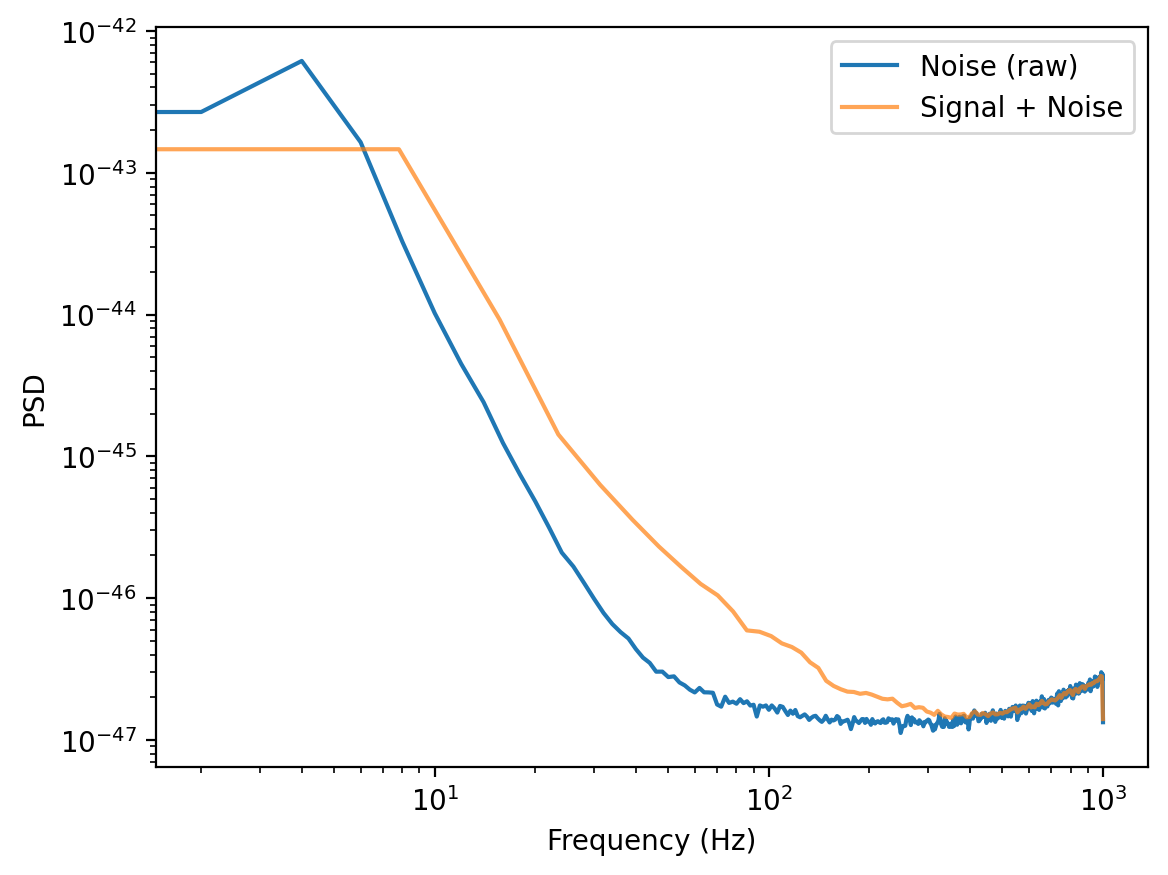

In [79]:
# Constants
G = 6.67430e-11
c = 2.998e8
M_sun = 1.989e30
pc = 3.086e16

# Load data
TrainingData = scio.loadmat('../generate_ligo/noise.mat')
analysisData = scio.loadmat('../generate_ligo/data.mat')

# Convert data to CuPy arrays
dataY = cp.asarray(analysisData['data'][0])
# dataY = cp.asarray(analysisData['noise'][0])
nSamples = dataY.size
Fs = float(analysisData['samples'][0][0])  
# Fs = 2000
# Search range parameters
#                r  mc tc phi A  Δtd
rmin = cp.array([-2, 0, 0, 0, 0, 0])   # 对应参数范围下限`
rmax = cp.array([4, 3, 10, 2*np.pi, 1, 2])  # 对应参数范围上限

# Time domain setup
dt = 1/Fs  # 采样率Hz
t = np.arange(-90, 10, dt) 
T = nSamples/Fs
df = 1/T
Nyq = Fs/2

# PSD estimation (CPU operation)
training_noise = TrainingData['noise'][0]  # Get noise data
psdHigh = TrainingData['psd'][0]  # Get PSD data directly

# Calculate Welch periodogram
[f, pxx] = welch(training_noise, fs=Fs,
                 window='hamming', nperseg=int(Fs/2),
                 noverlap=None, nfft=None,
                 detrend=False)

# Smooth PSD
# smthOrdr = 10
# b = np.ones(smthOrdr)/smthOrdr
# pxxSmth = filtfilt(b, 1, pxx)

# Interpolate PSD
# kNyq = int(cp.floor(nSamples/2)) + 1
# posFreq = cp.arange(0, kNyq)*Fs/nSamples
# psdPosFreq = cp.asarray(interp1d(f, pxxSmth)(cp.asnumpy(posFreq)))

# Plot PSDs
plt.figure(dpi=200)
plt.plot(f, pxx, label='Noise (raw)')
# plt.plot(f, pxxSmth, label='Noise (smoothed)', linestyle='--')

# Convert data to CPU for Welch
dataY_cpu = cp.asnumpy(dataY)
[f, pxxY] = welch(dataY_cpu, fs=Fs,
                  window='hamming', nperseg=256,
                  noverlap=None, nfft=None,
                  detrend=False)

plt.plot(np.abs(f), pxxY, label='Signal + Noise', alpha=0.7)
plt.xlabel('Frequency (Hz)')
plt.ylabel('PSD')
plt.yscale('log')
plt.xscale('log')
# plt.xlim(0, 250)
plt.legend()
plt.savefig('output_psd.png', dpi=200, bbox_inches='tight')
plt.show()
plt.close()

In [80]:
# PSO input parameters
inParams = {
    'dataX': t,
    'dataY': dataY,
    # 'psdPosFreq': psdPosFreq,
    'sampFreq': Fs,
    'psdHigh':psdHigh,
    'rmin': rmin,
    'rmax': rmax,
}
# Number of PSO runs
nRuns = 30
# Run PSO optimization
outResults, outStruct = crcbqcpsopsd(inParams, {'maxSteps': 4000}, nRuns)

Run 30: 100%|██████████| 4000/4000 [00:09<00:00, 409.24it/s] 


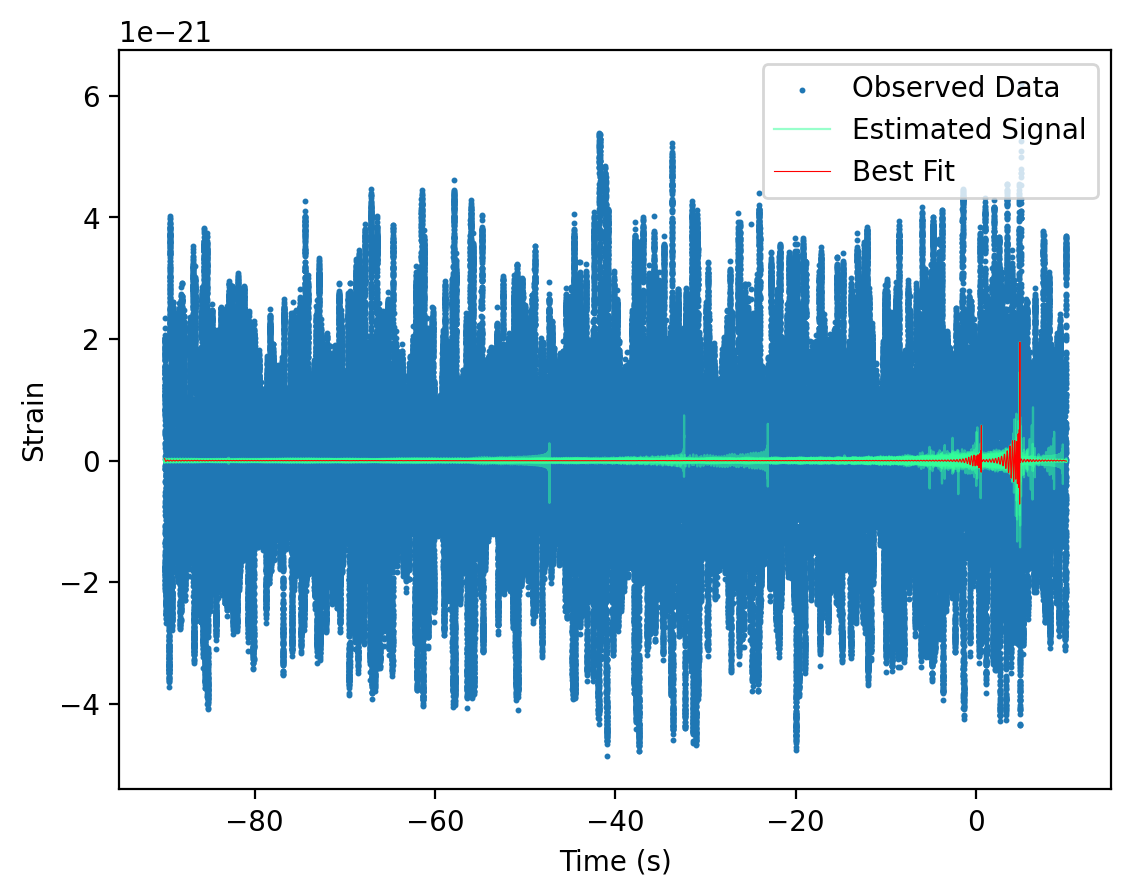

In [81]:
# Plotting results
fig = plt.figure(dpi=200)
ax = fig.add_subplot(111)

# Convert and get real parts of data
t = cp.asnumpy(t)
dataY = cp.asnumpy(dataY)
# Plot observed data
ax.scatter(t, dataY, marker='.', s=5, label='Observed Data')

# Plot all estimated signals
for lpruns in range(nRuns):
    est_sig = cp.asnumpy(cp.real(outResults['allRunsOutput'][lpruns]['estSig']))
    ax.plot(t, est_sig,
            color=[51/255, 255/255, 153/255], 
            lw=0.8, 
            alpha=0.5, 
            label='Estimated Signal' if lpruns == 0 else "_nolegend_")

# Highlight best signal
best_sig = cp.asnumpy(cp.real(outResults['bestSig']))
ax.plot(t, best_sig, 'red', lw=0.4, label='Best Fit')

# Set labels and legend
plt.xlabel('Time (s)')
plt.ylabel('Strain')
plt.legend(loc='upper right')  # Specify legend location explicitly

# Save and show plot
plt.savefig('output_signal.png', dpi=200, bbox_inches='tight')
plt.show()
plt.close()

In [82]:
print('\n============= Final Results =============')
print(f"Best Fitness (GLRT): {outResults['bestFitness']:.4f}")
print(f"r : {10**outResults['allRunsOutput'][outResults['bestRun']]['r']:.4f}")
print(f"Mc: {10**outResults['allRunsOutput'][outResults['bestRun']]['m_c']:.4f}")
print(f"tc: {outResults['allRunsOutput'][outResults['bestRun']]['tc']:.4f}")
print(f"phi_c: {outResults['allRunsOutput'][outResults['bestRun']]['phi_c']/np.pi:.4f}")
print(f"A: {outResults['allRunsOutput'][outResults['bestRun']]['A']:.4f}")
print(f"delta_t: {10 ** outResults['allRunsOutput'][outResults['bestRun']]['delta_t']:.4f}")
print(f"SNR: {cp.sqrt(-outResults['bestFitness']):.2f}")

for lpruns in range(nRuns):
    print(f"\nRun No.{lpruns+1}:")
    print(f"bestFitness={float(outStruct[lpruns]['bestFitness']):.4f}")
    print(f"r = {float(10 ** outResults['allRunsOutput'][lpruns]['r']):.4f}")
    print(f"m_c = {float(10 ** outResults['allRunsOutput'][lpruns]['m_c']):.4f}")
    print(f"tc = {float(outResults['allRunsOutput'][lpruns]['tc']):.4f}")
    print(f"phi_c = {float(outResults['allRunsOutput'][lpruns]['phi_c'])/np.pi:.4f}")
    print(f"A = {float(outResults['allRunsOutput'][lpruns]['A']):.4f}")
    print(f"delta_t = {float(10 ** outResults['allRunsOutput'][lpruns]['delta_t']):.4f}")
    print(f"SNR = {float(cp.sqrt(-outStruct[lpruns]['bestFitness'])):.2f}")


============= Final Results =============
Best Fitness (GLRT): -299.8210
r : 6129.1116
Mc: 395.9661
tc: 4.8463
phi_c: 1.0806
A: 0.2808
delta_t: 4.2724
SNR: 17.32

Run No.1:
bestFitness=-83.3908
r = 3850.8709
m_c = 29.1185
tc = 6.5133
phi_c = 1.5003
A = 0.4961
delta_t = 1.6443
SNR = 9.13

Run No.2:
bestFitness=-123.4671
r = 2.0823
m_c = 6.1623
tc = 5.3041
phi_c = 1.3304
A = 0.6818
delta_t = 2.0027
SNR = 11.11

Run No.3:
bestFitness=-297.4560
r = 63.4243
m_c = 135.9213
tc = 4.8668
phi_c = 1.0854
A = 0.4567
delta_t = 52.1813
SNR = 17.25

Run No.4:
bestFitness=-222.1192
r = 26.9017
m_c = 20.3482
tc = 4.9788
phi_c = 1.2651
A = 0.1440
delta_t = 1.1324
SNR = 14.90

Run No.5:
bestFitness=-94.2595
r = 1.3017
m_c = 175.3251
tc = 4.8367
phi_c = 1.5038
A = 0.5967
delta_t = 9.9967
SNR = 9.71

Run No.6:
bestFitness=-202.7639
r = 0.6745
m_c = 119.2308
tc = 4.6895
phi_c = 0.7797
A = 0.8357
delta_t = 4.6635
SNR = 14.24

Run No.7:
bestFitness=-235.2289
r = 0.0315
m_c = 149.1055
tc = 4.8256
phi_c = 0.09

In [83]:
def analyze_mismatch(data, h_lens, samples, psdHigh):
    # Convert inputs to CuPy arrays
    data_cupy = cp.asarray(data)
    h_lens_cupy = cp.asarray(h_lens)
    # def innerprodpsd(xVec, yVec, sampFreq, psdVals):
    #     fftX = cp.fft.fft(xVec)
    #     fftY = cp.fft.fft(yVec)
    #     psdVec4Norm = cp.concatenate([psdVals, psdVals[-2:0:-1]])
    #     return cp.real(cp.sum((fftX / psdVec4Norm) * cp.conj(fftY)) / (sampFreq * len(xVec)))
    # Calculate match value
    match_value = (innerprodpsd(h_lens_cupy, data_cupy, samples, psdHigh) /
                   cp.sqrt(innerprodpsd(h_lens_cupy, h_lens_cupy, samples, psdHigh) *
                           innerprodpsd(data_cupy, data_cupy, samples, psdHigh)))

    # Calculate mismatch and SNR
    e = 1 - match_value
    # snr = cp.sqrt(innerprodpsd(h_lens_cupy, data_cupy, samples, psdHigh))
    return e
bestData = outResults['bestSig']# + training_noise
bestData = cp.asarray(bestData)
dataY = cp.asarray(dataY) -cp.asarray(training_noise)
psdHigh = cp.asarray(psdHigh)

Epsilon = analyze_mismatch(bestData,dataY,Fs,psdHigh)
# snr = cp.sqrt(-outResults['bestFitness']) 
snr = cp.sqrt(innerprodpsd(bestData, dataY,Fs, psdHigh))
rou = cp.sqrt(-outResults['bestFitness']) ** (-2)
print(f"Epsolon:{Epsilon},rou:{rou},snr:{snr}")
if snr < 8:
    print('这是个纯噪声')
else:
    if Epsilon > rou:
        print('这是透镜化的信号')
    else:
        print("这是未透镜的信号")

Epsolon:0.9313887889829563,rou:0.003335323878177596,snr:16.693605188752276
这是透镜化的信号


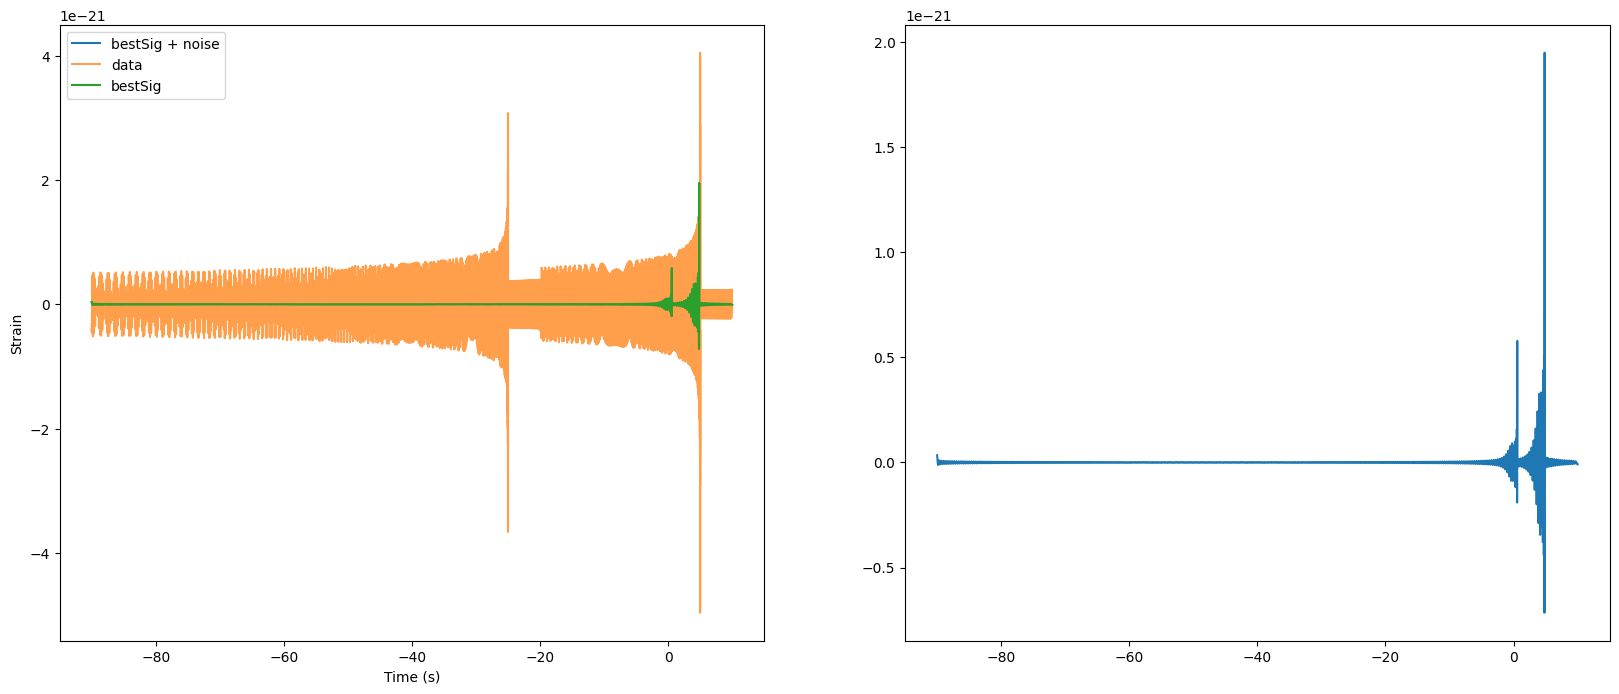

In [84]:
fig = plt.figure(figsize=(20,8))
plt.subplot(121)
plt.plot(t, cp.asnumpy(bestData),label = 'bestSig + noise')
plt.plot(t,cp.asnumpy(dataY),label = 'data',alpha = 0.75)
plt.plot(t,cp.asnumpy(outResults['bestSig']),label = 'bestSig')
plt.xlabel('Time (s)')
plt.ylabel('Strain')
plt.legend()

plt.subplot(122)
plt.plot(t,cp.asnumpy(outResults['bestSig']),label = 'bestSig')
plt.show()
